In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz, hilbert
import matplotlib.pyplot as plt
from pylab import *
from rtlsdr import *
from scipy import *
from pyargus.directionEstimation import *

def retira_NaN(signal):
    sinal_sem_nan = []
    for sample in signal:
        if (math.isnan(np.imag(sample)) or math.isnan(np.real(sample))):
            sinal_sem_nan.append(0)
        else:
            sinal_sem_nan.append(sample)
    return sinal_sem_nan

def hilbert_of_complex(signal):
    signal_real = real(signal)
    signal_imag = imag(signal)
    signal_real_ = hilbert(signal_real)
    signal_imag_ = hilbert(signal_imag)
    hilbert_signal = signal_real_ + signal_imag_*1j
    
    return signal + hilbert_signal*1j
 
def cross_corr(y1, y2):

    if len(y1) != len(y2):
        raise ValueError('Inputs com len diferentes')

    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    corr = np.correlate(y1, y2, mode='same')
    unbiased_sample_size = np.correlate(
      np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    shift = len(y1) // 2

    max_corr = np.max(abs(corr))
    argmax_corr = np.argmax(corr)
    return argmax_corr - shift

def sincroniza_sinal(lag,signal1,signal2):
    k1 = signal2[abs(lag):]
    k2 = signal1[:len(k1)]
    return k1,k2

def lag_GCCphat(signal1,signal2):
    N=2*len(signal1)
    X1aux=scipy.fft(signal1,N)
    X2aux=scipy.fft(signal2,N)
    r12=np.real(scipy.fft.fftshift(scipy.fft.ifft(X1aux*np.conj(X2aux)/(1e-6+abs(X1aux*X2aux)))))
    return int(np.argmax(r12) - len(r12)/2)

#def read_file_IQ(dire):
#    data = open(dire, 'rb').read()
#    integer_data = [int(i) - 128 for i in data]
#    signal = [complex(a,b) for a,b in zip(integer_data[0::2], integer_data[1::2])]
#    return signal

def read_file_IQ(dire):
    samples = np.fromfile(dire, np.complex64)
    return samples

In [13]:
#a principio só com a primeira parte de sinc

dire_sinal1 = "/home/rafael/DoA/sinalL.bin"
sinal1 = read_file_IQ(dire_sinal1)

dire_sinal2 = "/home/rafael/DoA/sinalR.bin"
sinal2 = read_file_IQ(dire_sinal2)

samples_sinc_interval = int(len(sinal1)/3)

#######lag de defasagem######

lag = cross_corr(sinal1[:samples_sinc_interval],sinal2[:samples_sinc_interval])
#lag = lag_GCCphat(sinal1[:samples_sinc_interval],sinal2[:samples_sinc_interval])

sinal_real1 = sinal1[samples_sinc_interval:2*samples_sinc_interval]
sinal_real2 = sinal2[samples_sinc_interval:2*samples_sinc_interval]

sinal_real1, sinal_real2 = sincroniza_sinal(lag, sinal_real2, sinal_real1)

sinal_real1 = retira_NaN(sinal_real1)
sinal_real2 = retira_NaN(sinal_real2)

In [14]:
b, a = butter(10, 0.2, btype='lowpass', analog=False)
sinal_real1 = lfilter(b, a, sinal_real1)
sinal_real2 = lfilter(b, a, sinal_real2)

(array([3.75902350e+59, 3.72754685e+59, 3.69993953e+59, ...,
        3.87671707e+59, 3.83360265e+59, 3.79437365e+59]),
 array([-1.        , -0.99804688, -0.99609375, ...,  0.99414062,
         0.99609375,  0.99804688]))

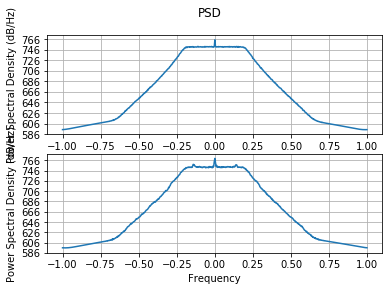

In [15]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('PSD')
ax1.psd(sinal_real1, NFFT = 1024)
ax2.psd(sinal_real2, NFFT = 1024)

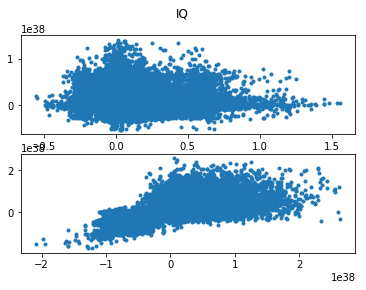

In [16]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('IQ')
ax1.plot(np.real(sinal_real1), np.imag(sinal_real1), '.')
ax2.plot(np.real(sinal_real2), np.imag(sinal_real2), '.')


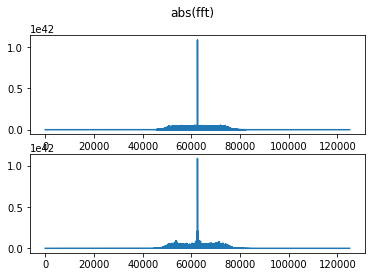

In [17]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('abs(fft)')
ax1.plot(np.abs(np.fft.fftshift(np.fft.fft(sinal_real1))))
ax2.plot(np.abs(np.fft.fftshift(np.fft.fft(sinal_real2))))

Minimum alias angle 0.00 
Maximum alias angle 0.00 
Minimum alias angle 0.00 
Maximum alias angle 0.00 
Minimum alias angle 0.00 
Maximum alias angle 0.00 
Minimum alias angle 0.00 
Maximum alias angle 0.00 
Minimum alias angle 0.00 
Maximum alias angle 0.00 


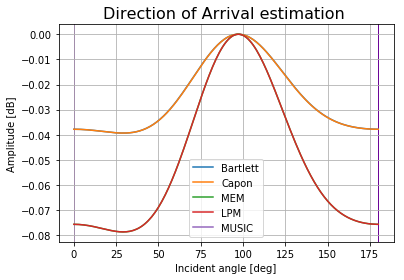

In [23]:
M = 2
d = 0.5

rec_signal = np.array([sinal_real1, sinal_real2])

rec_signal = rec_signal - np.mean(rec_signal)

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

R = forward_backward_avg(R)

# GGera vetor scan       
array_alignment = np.arange(0, M, 1) * d
incident_angles= np.arange(0,181,1)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

# DOA 
Bartlett = DOA_Bartlett(R, ula_scanning_vectors)    
Capon = DOA_Capon(R, ula_scanning_vectors)
MEM = DOA_MEM(R, ula_scanning_vectors,  column_select = 0)
LPM = DOA_LPM(R, ula_scanning_vectors, element_select = 1)
MUSIC = DOA_MUSIC(R, ula_scanning_vectors, signal_dimension = 2)

# Plot 
axes = plt.axes()
DOA_plot(Bartlett, incident_angles, log_scale_min = -50, axes=axes)
DOA_plot(Capon, incident_angles, log_scale_min = -50, axes=axes)
DOA_plot(MEM, incident_angles, log_scale_min = -50,axes=axes)
DOA_plot(LPM, incident_angles, log_scale_min = -50, axes=axes)
DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes)
axes.legend(("Bartlett","Capon","MEM","LPM","MUSIC"))

In [24]:
np.argmax(Capon)

97